# Imports

In [1]:
import Pkg

Pkg.activate("../")

 Activating environment at `/mnt/c/Users/sfrie/Documents/Code/julia/PolyFields.jl/Project.toml`


In [2]:
using BenchmarkTools

using FFTW
using LinearAlgebra
using JSON

using StaticArrays
using Random
using Statistics
using LineSearches

using Plots

In [3]:
using PolyFields

┌ Info: Precompiling PolyFields [537b8fae-343b-4751-aed0-0d38a89c053e]
└ @ Base loading.jl:1278


# Examples

## MDE Solutions

### Finite Difference Toy Model - Sec 3.6.1

In [ ]:
N = 200
b = 1/(sqrt(N/6))
L = 10.0

W(x, L) = 1 - 2*sech(3*(x - L/2)/2)^2

;

In [ ]:
Nx = 32
Ns = 200

dx = L/(Nx-1)
ds = N/(Ns-1)

x = collect(range(0, L, step = dx))
s = collect(range(0, N, step = ds))
wx = W.(x, L)

;

In [ ]:
q = ones(Nx, Ns)
q[:,1] .= 1.0

tol = 1e-6
max_steps = 300

norm_prev = norm(q)
norm_curr = 0.0

step = 1
while step <= max_steps
    step += 1
    norm_prev = norm(q)
    
    if step % 25 == 0
        println("Calculating for step $(step).")
    end
    
    # Finite diff the propagator matrix
    for j in 1:Nx
        for n in 1:Ns-1
            # PBC in spatial dimension
            jp1 = mod1(j+1, Nx)
            jm1 = mod1(j-1, Nx)

            rhs = (b^2/6)*((q[jp1, n] - 2*q[j,n] + q[jm1,n])/(dx^2)) - q[j,n]*wx[j]/N
            q[j,n+1] = q[j,n] + ds*rhs
        end
    end
    
    norm_curr = norm(q)
    if abs(norm_prev - norm_curr) < tol
        print("Tolerance reached at step $(step) -- breaking.")
        break
    end
end  

In [ ]:
plot(x, q[:,end], label = "W(x)")
plot!(x, wx, label = "q(x, N)")

plot!(legend = :bottomright, size = (400, 275))

### Crank-Nicolson Scheme - Sec 3.6.1

In [21]:
N = 50
b = 1.0/(sqrt(N/6))
L = 5.0

W(x, L) = 1 - 2*sech(3*(x - L/2)/2)^2

;

In [22]:
Nx = 128
Ns = 200

dx = L/(Nx-1)
ds = N/(Ns-1)

x = collect(range(0, L, step = dx))
s = collect(range(0, N, step = ds))
wx = W.(x, L)

;

In [23]:
q = zeros(Nx, Ns)
q[:,1] .= 1.0

# Operators for solver
WX = diagm(0 => wx/N)

# Init T w/ PBC
T = zeros(Nx, Nx)
for j in 1:Nx
    jp1 = mod1(j+1, Nx)
    jm1 = mod1(j-1, Nx)
    
    T[j,j] = -2.0
    T[j,jp1] = 1.0
    T[j,jm1] = 1.0
end

# Matrix operators for solver
TW = (I - (ds/2)*WX + (b^2*ds)/(12*dx^2)*T)
TWM = (I + (ds/2)*WX - (b^2*ds)/(12*dx^2)*T)

# Matrix solve for each chain discretization
for n in 1:Ns-1
    q[:,n+1] = TWM \ TW * q[:,n]
end

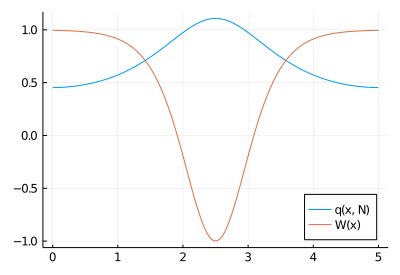

In [24]:
plot(x, q[:,end], label = "q(x, N)")
plot!(x, wx, label = "W(x)")

plot!(legend = :bottomright, size = (400, 275))

### Psuedo-Spectral Scheme - Sec. 3.6.2

In [ ]:
N = 50
b = 1/(sqrt(N/6))
L = 10.0

W(x, L) = 1 - 2*sech(3*(x - L/2)/2)^2

;

In [ ]:
Nx = 32
Ns = 200

dx = L/Nx
ds = N/Ns

x = collect(range(0; step = dx, length = Nx))
wx = W.(x, L)

;

In [ ]:
q = zeros(Complex{Float64}, Nx, Ns)
q[:,1] .= 1.0

# Operators for solver
LW = exp.(-(wx/N)*ds/2)

LD = zeros(Nx)
for idx = 0:Nx-1
    jx = idx < Nx/2 ? idx : Nx-idx
    LD[idx+1] = exp(-2*pi^2*b^2*ds*jx^2/(3*L^2))
end

for n = 1:Ns-1
    qn13 = LW .* q[:,n]
    an13 = fft(qn13)
    hj = LD .* an13
    qn23 = ifft(LD .* an13)
    q[:,n+1] = LW .* qn23
end

;

In [ ]:
Qw = sum(q[:, end]) / L
rho = sum(q .* reverse(q, dims = 2), dims = 2) / L / Qw
rho *= L / N


;

In [ ]:
plot(x, real(q[:,end]), label = "q(x, N)")
plot!(x, real(rho), label = "rho(x)")
plot!(x, wx, label = "W(x)")

plot!(legend = :bottomright, size = (400, 275))

### Higher Dimensional Solver

In [ ]:
N = 50
b = 1/(sqrt(N/6))
Lx = 20.0
Ly = 20.0

e1 = [Lx, 0.0]
e2 = [0.0, Ly]

#W(x, y, Lx, Ly) = cos(3*pi*x/Lx) * sin(4*pi*y/Ly)
W(x, y, Lx, Ly) = (1 - 2*(sech(3(y - Ly/2)/2))^2) * (1 - 2*(sech(3(x - Lx/2)/2))^2)

;

In [ ]:
Nx = 64
Ny = 64

dx = Lx/Nx
dy = Ly/Ny

ds = 0.1
Ns = trunc(Int, N/ds)

x = collect(range(0; length = Nx, step = dx))
y = collect(range(0; length = Ny, step = dy))

wr = zeros(Nx, Ny)
for i = 1:Nx
    for j = 1:Ny
        wr[i, j] = W(x[i], y[j], Lx, Ly)
    end
end

;

In [ ]:
q = zeros(Complex{Float64}, Nx, Ny, Ns)
q[:, :, 1] .= 1.0

# Operators for solver
LW = zeros(Nx, Ny)
LD = zeros(Nx, Ny)

@. LW = exp(-(wr/N)*ds/2)

for idx in CartesianIndices((1:Nx, 1:Ny))
    jx = idx[1] <= Nx/2 ? idx[1] : Nx-idx[1]
    jy = idx[2] <= Ny/2 ? idx[2] : Ny-idx[2]
    
    LD[idx] = exp(-2*pi^2*b^2*ds*jx^2/(3*Lx^2)) * exp(-2*pi^2*b^2*ds*jy^2/(3*Ly^2))
end

function mde_solve!(q, LW, LD)
    Nx, Ny, Ns = size(q)
    
    FT = plan_fft(q[:, :, 1])
    iFT = inv(FT)
    qh =  zeros(Complex{Float64}, Nx, Ny)
    
    @views for n = 2:Ns
        q[:, :, n] .= LW .* q[:, :, n-1]
        mul!(qh, FT, q[:, :, n])
        qh .*= LD
        mul!(q[:, :, n], iFT, qh)
        q[:, :, n] .*= LW
    end 
end

@time mde_solve!(q, LW, LD)

In [ ]:
Qw = sum(q[:, :, end]) / Lx / Ly
rho = dropdims(sum(q .* reverse(q, dims = 3), dims = 3), dims = 3) / Lx / Ly / Qw
rho *= Lx * Ly / N


;

In [ ]:
plot(x, y, wr, st = :surface, color = :blues)
plot!(x, y, real(q[:,:,end]), st = :surface, color = :reds)

# SCFT Program

In [22]:
dims = (64, 1, 1)
cell = Cell1D(15)

;

In [24]:
amon = Monomer(; id = 1, vol = 1.0, charge = 1.0)
bmon = Monomer(; id = 2, vol = 1.0, charge = 0.0)
#cmon = Monomer(; id = 3, vol = 2.0)

sys = FieldSystem(dims, cell; monomers = [amon, bmon], ensemble = Canonical)

# Add species 
#point = Point(cmon)
chain = Diblock(amon, bmon, 500, 0.5, 1.0, 1.0, 100)
#add_species!(sys, point, 0.5)
add_species!(sys, chain, 1.0)

# Interactions
itx = FloryInteraction()
set_interaction!(itx, amon.id, bmon.id, 0.11)
add_interaction!(sys, itx)

# # Initializatione
#fieldinit!(sys, "../examples/seeds/cyl2d.json", load_cell = false)
fieldinit!(sys; scale = 0.1)

# ;

In [25]:
updater = AndersonUpdater(nhist = 50, iter_euler = 1, lam_euler = 0.001)
PolyFields.setup!(updater, sys)

In [26]:
for i = 1:100
    step!(updater)
end

In [27]:
field_error(sys)

2.5374236427742005e-12

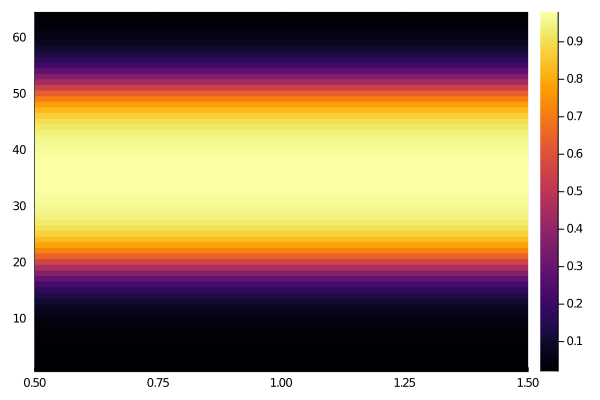

In [28]:
heatmap(sys.density[1][:,:,1])

In [145]:
opts = SCFTOptions(steps = 2500, nsout = 100, rtol = 1e-5, stol = 1e-6)

updater = MomentumUpdater(method = "MOM", gamma = 0.9, lam = 0.01, beta2 = 0.999)

@time res = scft!(sys, updater; opts = opts)

Step (0     /  2500): rerr = 8.236921e-03, fhelm = 5.33078e-02
Step (100   /  2500): rerr = 4.115335e-03, fhelm = 5.32385e-02
Step (200   /  2500): rerr = 1.894837e-03, fhelm = 5.31988e-02
Step (300   /  2500): rerr = 8.749782e-04, fhelm = 5.31811e-02
Step (400   /  2500): rerr = 4.049819e-04, fhelm = 5.31731e-02
Step (500   /  2500): rerr = 1.880308e-04, fhelm = 5.31695e-02
Step (600   /  2500): rerr = 8.773884e-05, fhelm = 5.31679e-02
Step (700   /  2500): rerr = 4.127256e-05, fhelm = 5.31672e-02
Step (800   /  2500): rerr = 1.966153e-05, fhelm = 5.31669e-02
Converged @ step = 894: rerr = 9.960968e-06, fhelm = 5.31667e-02
  0.211202 seconds (25.47 k allocations: 527.875 KiB)


PolyFields.SCFTResults
  time: Float64 0.211163263
  nsteps: Int64 894
  converged: Bool true
  rerr: Float64 9.960967822306453e-6
  serr: Float64 0.0
  fhelm: Float64 0.053166717805607


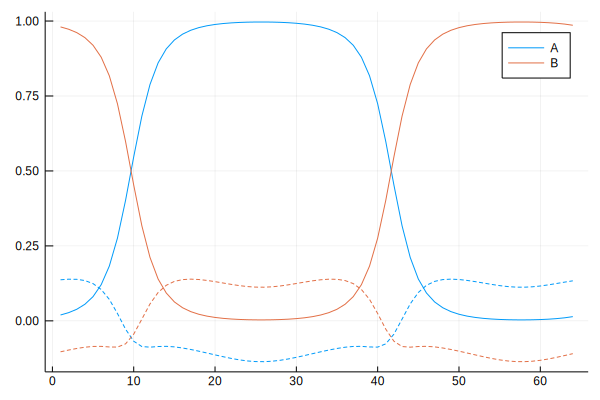

In [146]:
plot(sys.density[1][:,1,1], label = "A")
plot!(sys.fields[1][:,1,1], primary = false, ls = :dash)

plot!(sys.density[2][:,1,1], label = "B")
plot!(sys.fields[2][:,1,1], primary = false, ls = :dash)

# plot!(sys.density[3][:,1,1], label = "C")
# plot!(sys.fields[3][:,1,1], primary = false, ls = :dash)

In [78]:
free_energy(sys), free_energy_bulk(sys)

(0.05316658720043248, 0.115)

In [79]:
sys.density_sum

64×1×1 Array{Float64,3}:
[:, :, 1] =
 1.0000003041648937
 1.000000408038523 
 1.0000003125453962
 1.0000003867562524
 1.0000002623179027
 1.0000002131263355
 0.9999999276735402
 0.9999998160742647
 0.9999998367235798
 1.0000002207774035
 1.0000002686740124
 1.0000001454964178
 0.9999998186721287
 ⋮                 
 1.0000001173177606
 1.00000024334035  
 1.000000185792256 
 1.0000000146483834
 1.0000000183211364
 1.000000014975156 
 1.0000001677648611
 1.0000001599139   
 1.0000000915134266
 1.0000003562815147
 1.000000276236884 
 1.0000004149100212

## Plotting

In [ ]:
x = 10.0 * sys.fields[2]

plot = volume(x, algorithm = :mip)
cm = colorlegend(
     plot[end],             # access the plot of Scene p1
     raw = true,          # without axes or grid
     camera = campixel!,  # gives a concrete bounding box in pixels
                          # so that the `vbox` gives you the right size
     width = (            # make the colorlegend longer so it looks nicer
         30,              # the width
         500              # the height
     )
)

scene_final = vbox(plot, cm) # put the colorlegend and the plot together in a `vbox`